In [1]:
import os

import numpy as np
import scipy

import stft

from wav import wavPlayer, load_wav
from nmf import ANLS, subproblem

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting routine

In [16]:
def plot_spectrogram(signal, title):
    """
    Plot spectrogram of the signal using STFT and params described below in the code.
    
    Args:
        signal(ndarray): 1D-signal
        title(str): title of the plot
        
    Return:
        None
    """
    
    # here vmax=60 is put empirically for this exact audio files
    plt.specgram(signal, 
                 NFFT=framelength, 
                 Fs=fs, 
                 noverlap=framelength - hopsize, 
                 window=mlab.window_hanning, 
                 vmax=60)
    
    plt.xlim([0, len(signal) * 1. / fs])
    plt.grid("on")
    plt.title(title, fontsize=14)
    plt.xlabel("Time, s", fontsize=14)
    plt.ylabel("Frequency, Hz", fontsize=14)

In [17]:
def plot_signal(signal, title):
    """
    Plot value of the signal.
    
    Args:
        signal(ndarray): 1D-signal
        title(str): title of the plot
        
    Return:
        None
    """
    
    plt.plot(np.arange(len(signal)) * 1. / fs, signal)
    plt.title(title, fontsize=14)
    plt.ylim([-20000, 20000])
    plt.xlabel("Time, s", fontsize=12)
    plt.grid("on")

# Parameters initialization

In [18]:
framelength = 512
hopsize = 128
window = scipy.signal.hanning

# Reading piano signal

In this example we consider a sequence of the piano notes concatenated in the random order

In [21]:
s_piano = np.array([0], dtype=np.int16)
# reading filenames of all the notes played
# taking only 4 of them and doubling
filelist = os.listdir("../data/piano")[1:5] * 2
# permute in the random order
filelist = np.random.permutation(filelist)
# read audios
for filename in filelist:
    fs, note = load_wav(os.path.join("../data/piano/", filename))
    s_piano = np.append(s_piano, note)
# final signal
s_piano = s_piano[1:]

Visualization of the signal

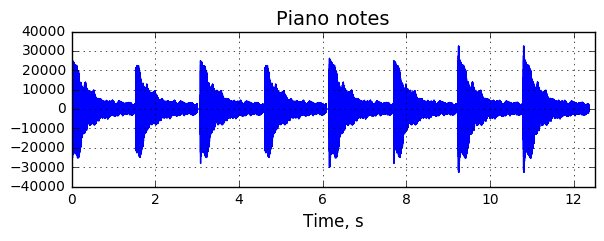

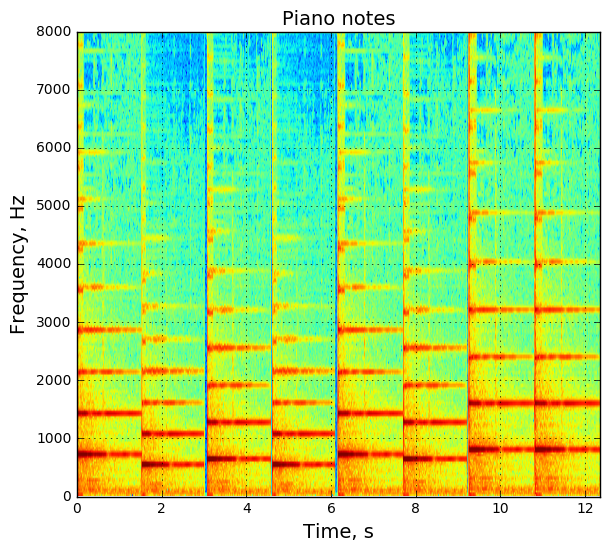

In [22]:
plt.figure(figsize=(6.75,2))
plot_signal(s_piano, "Piano notes")
plt.ylim([-40000, 40000])
plt.xlim([0, 12.5])
# plt.savefig("../presentation/piano_signal.png", bbox_inches="tight")
plt.show()
plt.figure(figsize=(6.75, 6))
plot_spectrogram(s_piano, "Piano notes")
# plt.savefig("../presentation/piano_spec.png", bbox_inches="tight")

wavPlayer(s_piano, fs)

# Building the spectrogram

In [23]:
S_piano = stft.spectrogram(s_piano, framelength, hopsize, window=window)
S_piano = np.array(S_piano)
V_piano = np.abs(S_piano)

# NMF

Here we do NMF with $\text{rank} = 4$, because we exactly know how many building blocks are contained in the signal $-$ 4 notes were played.

In [24]:
W_piano, H_piano = ANLS(V_piano, rank=4)

# Visualization of Vocabulary $\text{W}$ and Time-Activation matrix $\text{H}$

Time and frequency limits

In [25]:
t_piano = np.linspace(0, len(s_piano) * 1. / fs, H_piano.shape[1]) 
f_piano = np.fft.rfftfreq(framelength, 1. / fs)

Here is $\text{W}^{\text{T}}$

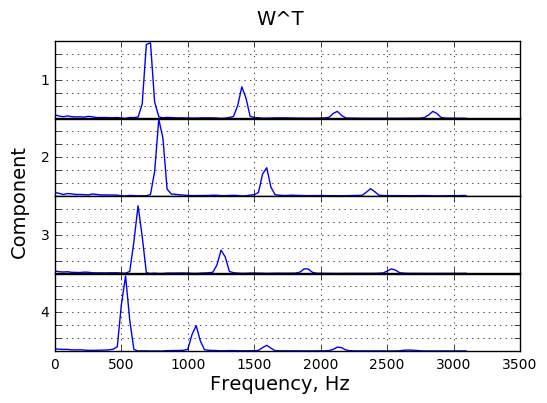

In [26]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.001)

for i in range(W_piano.shape[1]):
    plt.subplot(W_piano.shape[1], 1, i + 1)
    plt.plot(f_piano[:100], W_piano.T[i][:100])
    if i != W_piano.shape[1] - 1:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.grid("on")
    cur_y_ticks = plt.gca().get_yticks()
    new_y_ticks = np.linspace(cur_y_ticks[0], 
                              cur_y_ticks[-1], 
                              7)
    plt.yticks(new_y_ticks, ["", "", "", str(i + 1), "", "", ""])
    
plt.suptitle("W^T", fontsize=14)
fig.text(0.5, 0.03, "Frequency, Hz", ha='center', fontsize=14)
fig.text(0.05, 0.5, "Component", va='center', rotation='vertical', fontsize=14)

# plt.savefig("../presentation/W_piano.png", bbox_inches="tight")/

We can distinctly see 4 different patterns corresponding to 4 different notes being played.

Now matrix $\text{H}$

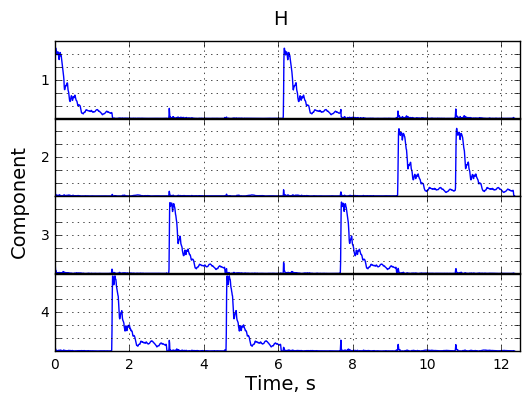

In [27]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.001)

for i in range(H_piano.shape[0]):
    plt.subplot(H_piano.shape[0], 1, i + 1)
    plt.plot(t_piano, H_piano[i])
    if i != H_piano.shape[0] - 1:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.grid("on")
    cur_y_ticks = plt.gca().get_yticks()
    new_y_ticks = np.linspace(cur_y_ticks[0], 
                              cur_y_ticks[-1], 
                              7)
    plt.yticks(new_y_ticks, ["", "", "", str(i + 1), "", "", ""])
    plt.xlim([0, 12.5])
    
plt.suptitle("H", fontsize=14)
fig.text(0.5, 0.03, "Time, s", ha='center', fontsize=14)
fig.text(0.05, 0.5, "Component", va='center', rotation='vertical', fontsize=14)

# plt.savefig("../presentation/H_piano.png", bbox_inches="tight")

Time activations of each pattern precisely corresponds to the time when each note was played and decays with time as it should be (it is like that if you're going to head the sound)